Carga de librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Datos

Funciones para transformar los datos

In [2]:
import numpy as np

def aplanar(datos, cantidad=10):
  datos = np.split(datos, cantidad)
  return np.array([ejem.flatten(order='C') for ejem in datos])

def des_aplanar(datos, k=7, j=5):
  datos = np.array(datos)
  return np.array([ejem.reshape((k, j), order='C') for ejem in datos])

def binario_a_matriz(datos):
  matrices = []
  for caracter in datos:
    matriz = []
    for byte in caracter:
      fila = [(byte >> i) & 1 for i in range(4, -1, -1)]
      matriz.append(fila)
    matrices.append(matriz)
  return np.array(matrices)

def graficar_matrices(mats, titulo=""):
  n = len(mats)
  fig, axes = plt.subplots(1, n, figsize=(n * 2, 3))
  if n == 1:          # cuando n = 1, axes no es lista
    axes = [axes]

  for i, ax in enumerate(axes):
    ax.imshow(mats[i], cmap="gray_r", interpolation="nearest")  # 1→negro
    ax.axis("off")
    ax.set_title(f"Gen {i+1}")

  if titulo:
    fig.suptitle(titulo, fontsize=12, y=1.05)
  plt.tight_layout()
  plt.show()

Transformación de los datos

In [3]:
datos = [
    [0x0e, 0x11, 0x17, 0x15, 0x17, 0x10, 0x0f],  # @
    [0x04, 0x0a, 0x11, 0x11, 0x1f, 0x11, 0x11],  # A
    [0x1e, 0x11, 0x11, 0x1e, 0x11, 0x11, 0x1e],  # B
    [0x0e, 0x11, 0x10, 0x10, 0x10, 0x11, 0x0e],  # C
    [0x1e, 0x09, 0x09, 0x09, 0x09, 0x09, 0x1e],  # D
    [0x1f, 0x10, 0x10, 0x1c, 0x10, 0x10, 0x1f],  # E
    [0x1f, 0x10, 0x10, 0x1f, 0x10, 0x10, 0x10],  # F
    [0x0e, 0x11, 0x10, 0x10, 0x13, 0x11, 0x0f],  # G
    [0x11, 0x11, 0x11, 0x1f, 0x11, 0x11, 0x11],  # H
    [0x0e, 0x04, 0x04, 0x04, 0x04, 0x04, 0x0e],  # I
    [0x1f, 0x02, 0x02, 0x02, 0x02, 0x12, 0x0c],  # J
    [0x11, 0x12, 0x14, 0x18, 0x14, 0x12, 0x11],  # K
    [0x10, 0x10, 0x10, 0x10, 0x10, 0x10, 0x1f],  # L
    [0x11, 0x1b, 0x15, 0x11, 0x11, 0x11, 0x11],  # M
    [0x11, 0x11, 0x19, 0x15, 0x13, 0x11, 0x11],  # N
    [0x0e, 0x11, 0x11, 0x11, 0x11, 0x11, 0x0e],  # O
    [0x1e, 0x11, 0x11, 0x1e, 0x10, 0x10, 0x10],  # P
    [0x0e, 0x11, 0x11, 0x11, 0x15, 0x12, 0x0d],  # Q
    [0x1e, 0x11, 0x11, 0x1e, 0x14, 0x12, 0x11],  # R
    [0x0e, 0x11, 0x10, 0x0e, 0x01, 0x11, 0x0e],  # S
    [0x1f, 0x04, 0x04, 0x04, 0x04, 0x04, 0x04],  # T
    [0x11, 0x11, 0x11, 0x11, 0x11, 0x11, 0x0e],  # U
    [0x11, 0x11, 0x11, 0x11, 0x11, 0x0a, 0x04],  # V
    [0x11, 0x11, 0x11, 0x15, 0x15, 0x1b, 0x11],  # W
    [0x11, 0x11, 0x0a, 0x04, 0x0a, 0x11, 0x11],  # X
    [0x11, 0x11, 0x0a, 0x04, 0x04, 0x04, 0x04],  # Y
    [0x1f, 0x01, 0x02, 0x04, 0x08, 0x10, 0x1f],  # Z
    [0x0e, 0x08, 0x08, 0x08, 0x08, 0x08, 0x0e],  # [
    [0x10, 0x10, 0x08, 0x04, 0x02, 0x01, 0x01],  # \
    [0x0e, 0x02, 0x02, 0x02, 0x02, 0x02, 0x0e],  # ]
    [0x04, 0x0a, 0x11, 0x00, 0x00, 0x00, 0x00],  # ^
    [0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x1f],  # _
]

etiquetas = ['@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_']

matrices = binario_a_matriz(datos)

x = aplanar(matrices, len(matrices)) # Datos enchorizados

# Modelos

Modelo autoencoder

In [18]:
np.random.seed(11)
tf.random.set_seed(11)

entrada = Input(shape=(35,))

# Codificador
x1 = Dense(11, activation='sigmoid')(entrada)
#x1 = Dense(8, activation='sigmoid')(x1)
latente = Dense(2, activation='sigmoid', name='latente')(x1)

# Decodificador
x1 = Dense(11, activation='sigmoid')(latente)
#x1 = Dense(8, activation='sigmoid')(x1)
salida = Dense(35, activation='sigmoid', name='salida')(x1)

# Autoencoder
autoencoder = Model(inputs=entrada, outputs=salida)
autoencoder.compile(loss='mse', optimizer=Adam(0.001))

In [19]:
early_stop = EarlyStopping(
    monitor='loss',       # Podés usar 'val_loss' si tenés validación
    patience=20,          # Nº de épocas sin mejora antes de frenar
    restore_best_weights=True  # Para recuperar los pesos óptimos
)

Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2529
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2424
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2346 
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2281 
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2229 
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2187 
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2153 
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2126 
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2104 
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2086 
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2072 
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2061
Epoch 13/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2052
Epoch 14/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2045
Epoch 15/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

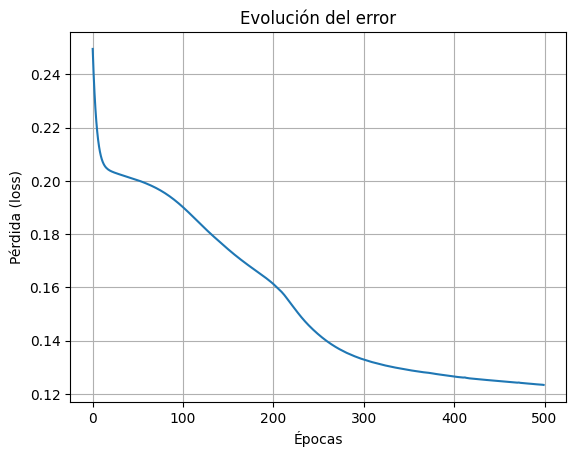

In [20]:
# Entrenamiento
historia = autoencoder.fit(x, x, epochs = 500, batch_size = 1, shuffle=True, callbacks=[early_stop])

#"""
plt.plot(historia.history['loss'])
plt.xlabel('Épocas')
plt.ylabel('Pérdida (loss)')
plt.title('Evolución del error')
plt.grid()
plt.show()
#"""

# Pruebas autoencoder

Guardar modelo

In [ ]:
autoencoder.save("autoencoder_entrenado.keras")

Cargar modelo

In [8]:
from keras.models import load_model

autoencoder = load_model("autoencoder_entrenado.keras")

Predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1]
[0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1]


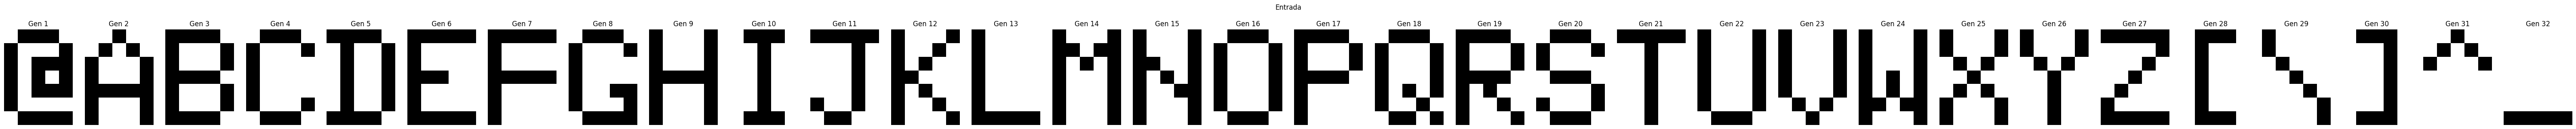

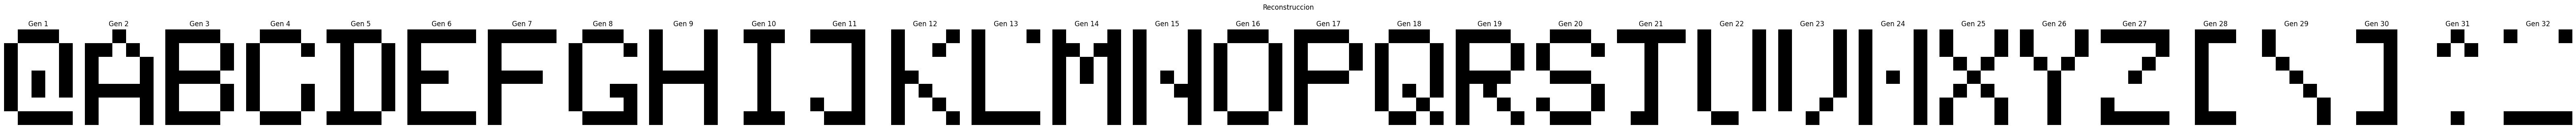

In [9]:
# Realizamos las predicciones y las redondeamos
ypred = autoencoder.predict(x)
reconstruccion = np.round(ypred).astype(int)

# Comparamos alguna
print(reconstruccion[1])
print(x[1])

# Las reconstruimos y graficamos el antes y después
graficar_matrices(des_aplanar(x, 7, 5), "Entrada")
matriz_nueva2 = des_aplanar(reconstruccion, 7, 5)
graficar_matrices(matriz_nueva2, "Reconstruccion")

# Modelo Encoder

Función para graficar capa latente

In [10]:
def graficar_capa_latente(codificados, etiquetas, fontsize=12, fcolor='black'):
  plt.figure(figsize=(10,8))
  plt.scatter(codificados[:,0], codificados[:,1], color='white')

  for i, etiqueta in enumerate(etiquetas):
      x1, y1 = codificados[i, 0], codificados[i, 1]
      texto = plt.text(x1, y1, etiqueta, fontsize=fontsize, ha='center', va='center', color='white')
      texto.set_path_effects([
          path_effects.Stroke(linewidth=(int(fontsize/8)), foreground=fcolor),  # contorno negro
          path_effects.Normal()  # texto original encima
      ])
  
  #plt.title('Representaciones latentes con contorno en las etiquetas')
  # Si se usa referencia el gráfico no debe tener titulo
  plt.grid(True)
  plt.xlim(-0.05, 1.05)
  plt.ylim(-0.05, 1.05)
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


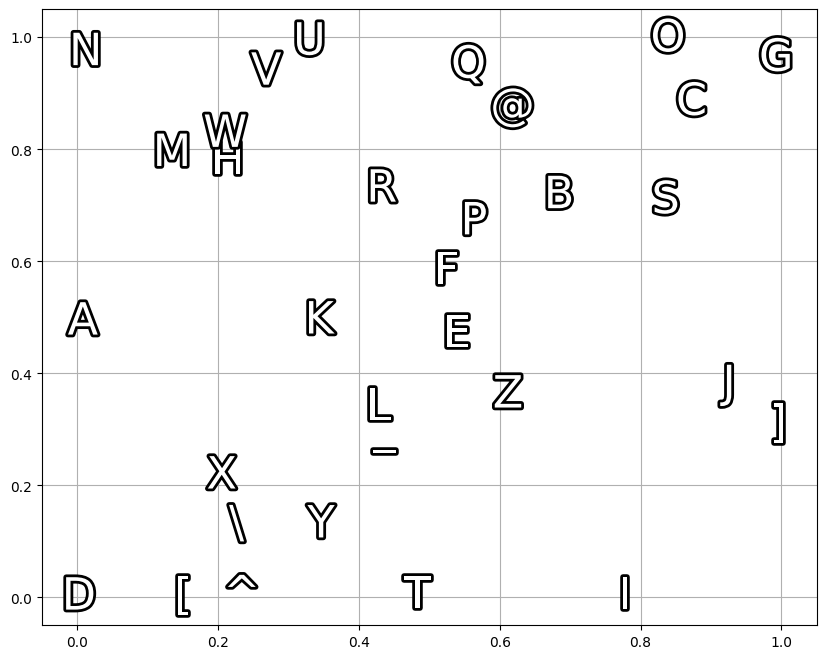

In [11]:
# Definir modelo para capa latente
codificador = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latente').output)

# Obtener embeddings latentes
codificados1 = codificador.predict(x)

graficar_capa_latente(codificados1, etiquetas, 32)

In [12]:
import json

codificados_puntos = np.round(codificados1, 2)

codificados_redondeados = [[round(x, 2) for x in par] for par in codificados_puntos.tolist()]

print(etiquetas)
print(json.dumps(codificados_redondeados))

['@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_']
[[0.62, 0.88], [0.01, 0.49], [0.68, 0.72], [0.87, 0.88], [0.0, 0.0], [0.54, 0.47], [0.52, 0.58], [0.99, 0.96], [0.21, 0.78], [0.78, 0.0], [0.93, 0.38], [0.34, 0.49], [0.43, 0.34], [0.13, 0.79], [0.01, 0.97], [0.84, 1.0], [0.56, 0.67], [0.56, 0.95], [0.43, 0.73], [0.84, 0.71], [0.48, 0.0], [0.33, 0.99], [0.27, 0.94], [0.21, 0.83], [0.21, 0.22], [0.35, 0.13], [0.61, 0.36], [0.15, 0.0], [0.23, 0.13], [1.0, 0.31], [0.23, 0.0], [0.44, 0.3]]


# Decoder

Modelo decoder

In [13]:
# Nueva entrada que representa la capa latente
entrada_latente = Input(shape=(2,), name='entrada_latente')

# Reutilizás las capas del modelo original
oculta2 = autoencoder.layers[-2]
salida = autoencoder.layers[-1]
x = oculta2(entrada_latente)
salida_decodificada = salida(x)
decodificador = keras.Model(inputs=entrada_latente, outputs=salida_decodificada)

ValueError: Input 0 of layer "dense_37" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (None, 2)

Función para "decodificar" puntos entre letras

In [ ]:
def representar_promedio_entre(codificados, etiquetas, punto1, punto2):
  valor1 = codificados[etiquetas.index(punto1)]
  valor2 = codificados[etiquetas.index(punto2)]
  nuevo_valor = (valor1 + valor2) / 2

  decodificado = decodificador.predict(np.array([nuevo_valor]))
  decodificado = np.round(decodificado).astype(int)

  matriz_decodificado = des_aplanar(decodificado, 7, 5)
  

  graficar_matrices(matriz_decodificado, titulo=f"{punto1} + {punto2}  →  punto medio")

In [ ]:
representar_promedio_entre(codificados1, etiquetas, "M", "P")

# Modelo eliminador de ruido

Función para agregar ruido en las entradas

In [ ]:
def agregar_ruido(x, prob=0.02):
  x_ruido = x.copy()
  cambios = 0

  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      if np.random.rand() < prob:
        cambios += 1
        x_ruido[i, j] = 1 if x[i, j] == 0 else 0
  print(f"Cambios realizados: {cambios}")
  return x_ruido

In [ ]:
x_ruido = agregar_ruido(x, 0.02)

Ahora entrenemos el modelo utilizando los datos con ruido como entrada

In [ ]:
w1a, w2a, w3a, w4a, b1a, b2a, b3a, b4a = autoencoder(x_ruido, x, 0.1, 5000)

# Pruebas eliminador de ruido

Y ahora probamos como elimina el ruido

In [ ]:
# Realizamos las predicciones y las redondeamos
ypred_ruido = predecir_autoencoder(x_ruido, w1a, w2a, w3a, w4a, b1a, b2a, b3a, b4a)
reconstruccion_ruido = np.round(ypred_ruido).astype(int)

# Comparamos alguna
print(reconstruccion_ruido[1])
print(x[1])

# Las reconstruimos y graficamos el antes y después
graficar_matrices(des_aplanar(x_ruido, 7, 5), "Entrada con ruido")
matriz_nueva2 = des_aplanar(reconstruccion_ruido, 7, 5)
graficar_matrices(matriz_nueva2, "Reconstruccion")